In [1]:
import tensorflow as tf
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture()
    return g, nn

In [4]:
graph, nn = load_arch("arch_invariant.py")

In [5]:
sess = tf.Session(graph=graph)

In [6]:
sess.run(tf.variables_initializer(graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

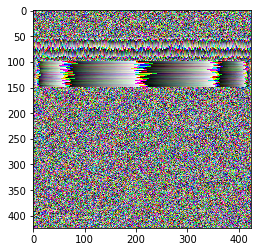

In [7]:
x = np.random.normal(size=(424, 424, 3))
x[50:100, :, :]  = np.sort(x[50:100, :, :], 0)
x[100:150, :, :] = np.sort(x[100:150, :, :], 1)
x[150:200, :, :] = np.sort(x[150:200, :, :], 2)
plt.imshow(x)

In [8]:
def dihedral(x, i):
    x = x.copy()
    if i & 4:
        x = np.transpose(x, (1, 0, 2))  # tau[4]
    if i & 1:
        x = x[:, ::-1, :]  # tau[1]
    if i & 2:
        x = x[::-1, :, :]  # tau[2]
    return x

In [9]:
xs = np.array([dihedral(x, i) for i in range(8)])

In [10]:
ps = sess.run(nn.tfp, feed_dict={nn.tfx: xs})
print(np.transpose(ps))

[[  4.60433483e-01   4.60431457e-01   4.60432351e-01   4.60432559e-01
    4.60434377e-01   4.60433185e-01   4.60433215e-01   4.60430652e-01]
 [  8.70961547e-02   8.70953649e-02   8.70967209e-02   8.70968699e-02
    8.70971680e-02   8.70972276e-02   8.70953575e-02   8.70965123e-02]
 [  4.52470362e-01   4.52473134e-01   4.52470809e-01   4.52470571e-01
    4.52468485e-01   4.52469677e-01   4.52471375e-01   4.52472895e-01]
 [  5.07625118e-02   5.07618450e-02   5.07631451e-02   5.07628769e-02
    5.07630445e-02   5.07628210e-02   5.07620834e-02   5.07627055e-02]
 [  3.63336429e-02   3.63335200e-02   3.63335684e-02   3.63339856e-02
    3.63341235e-02   3.63344103e-02   3.63332666e-02   3.63338068e-02]
 [  3.38181369e-02   3.38180475e-02   3.38180996e-02   3.38185020e-02
    3.38186286e-02   3.38188969e-02   3.38178240e-02   3.38183045e-02]
 [  2.51550344e-03   2.51547107e-03   2.51546875e-03   2.51548784e-03
    2.51549552e-03   2.51551671e-03   2.51544500e-03   2.51550204e-03]
 [  2.4292208

In [11]:
test = sess.run(nn.test, feed_dict={nn.tfx: xs})
test = np.reshape(test, (8, 8, -1))

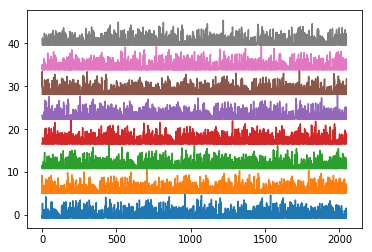

In [12]:
step = test[0].max() - test[0].min()
for i in range(8):
    plt.plot(test[i].flatten() + step * i)

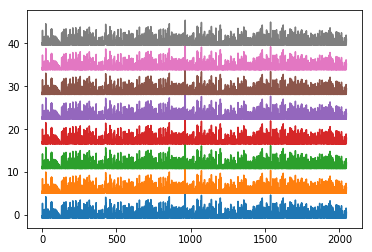

In [13]:
mt = np.array([ [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
# tau[mt[a,b]] = tau[a] o tau[b]

iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
# tau[iv[a]] is the inverse of tau[a]

for i in range(8):
    plt.plot(test[i][mt[i]].flatten() + step * i)